# Fearless5

### Motivation
Based on numerous observations on different datasets, it turned out that the simpler models achieve better results especially on 'Hourly', 'Weekly' and 'Yearly' datasets. On our hold-out experiments on 10K of the timeseries for the 'Yearly' dataset this method achieved better results compared to some other complex and established models such as holtwinters, arima, and a few more.


### Procedure
The method is fairly simple and tries to fit a combination of linear, exponential, and sinusoidal function on the trend and residuals of a time series. Using the seasonal decomposition of a time series one can obtain trend, seasonal and residual signals. The last part of each signal (after decompositions) with the size of the forecast horizon is picked to fit the functions. Then the obtained coefficients of the fitting processes is used to extrapolate in order to obtain a forecast for each signal. The seasonal signal obtained from the decomposition is periodic and can be used directly for the final prediction. To this end, the extrapolated values of the trend and residuals are added up together with the seasonal values to obtained the final prediction for each time serie.  

### Hacks
- The seasonal decomposition is done with freq=2 for timeseries of frequency 1 to obtain a non-constant / non-zero seasonal signal
- Different variations of fitting used to obtain final prediction but in general the idea was to fit linear/exponential curve to the trend and sinusoidal to the residuals due to observations on the dataset (simple but effective in many cases)
- On the hold-out dataset the errors for each variations can be observed and to be used in the final prediction. So that we know which variation worked best based on the hold-out, hopefully it performs well for the final submission as well.

### Limitation and criticism
This method is not wise approach for forecasting and I hope it would not be a disgrace to the forcasting community. It was meant to be an effective approach achieving better results in the M4 competition and hopefully it can once again shows that simplicity is better than complexity.

# Loading Dataset

## hold-out datasets

In [1]:
import pandas as pd
from os.path import join
import numpy as np

# Paths and file names
cutsize = 'full' # path to the dataset split size. other options: 1000, and 10000
path_train = join("cut",cutsize,"train")
path_test = join("cut",cutsize,"test")
files = ["Daily.csv", "Hourly.csv", "Monthly.csv", "Quarterly.csv", "Weekly.csv", "Yearly.csv"]

train = {}
test = {}

for f in files:
    train[f.split(".")[0]] = pd.read_csv(join(path_train, f))
    test[f.split(".")[0]] = pd.read_csv(join(path_test, f))    

# fix the IDs from training set
for key in test.keys():
    if cutsize != 'full':
        train[key] = train[key].drop(['Unnamed: 0'], axis=1)
        test[key] = test[key].drop(['Unnamed: 0'], axis=1)
    test[key] = pd.concat([train[key]['V1'], test[key]], axis=1)

## original dataset

In [2]:
files = ["Yearly-train.csv", "Weekly-train.csv", "Quarterly-train.csv", \
         "Monthly-train.csv", "Hourly-train.csv", "Daily-train.csv"]
path_m4 = join("M4DataSet") # path could be altered.
train_f = {}
for f in files:
    train_f[f.split("-")[0]] = pd.read_csv(join(path_m4, f))
    
# M4 info
m4info = pd.read_csv("cut/full/M4-info.csv")

In [3]:
plots_on = False # to turn the plots on or off

# Fitting functions

In [4]:
from jaguar.utils import load_serie_info
from jaguar.utils import deseasonalize
from jaguar.utils import mase, smape
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def func_lin(x, a, b, c):
    return a*x + b


def func_exp(x, a, b, c):
    return a * np.exp(-b * x) + c


def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset


def fit_trend(serie, func='lin'):
    tss = serie
    x = np.linspace(0,len(tss),len(tss))
    if func == 'exp':
        popt, pcov = curve_fit(func_exp, x, tss, maxfev= 10000)
        if plots_on:
            plt.plot(x, func_exp(x, *popt), 'r-', label="Fitted Curve")
            plt.plot(serie)
            plt.title('exponential fitting to the trend')
    else: 
        popt, pcov = curve_fit(func_lin, x, tss, maxfev= 10000)
        if plots_on:
            plt.plot(x, func_lin(x, *popt), 'r-', label="Fitted Curve")
            plt.plot(serie)
            plt.title('linear fitting to the trend')
    if plots_on:
        plt.show()
    return popt
    

def fit_resid(data, freq):
    # N = 1000 # number of data points
    N = data.shape[0]
    t = np.linspace(0, 4*np.pi, N)
    # data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

    guess_freq = freq 
    guess_amplitude = 3*np.std(data)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(data)

    p0=[guess_freq, guess_amplitude,
        guess_phase, guess_offset]

    # now do the fit
    fit = curve_fit(my_sin, t, data, p0=p0, maxfev=10000)

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = my_sin(t, *p0)

    # recreate the fitted curve using the optimized parameters
    data_fit = my_sin(t, *fit[0])

    if plots_on:
        plt.plot(data, '.')
        plt.plot(data_fit, label='after fitting')
        plt.plot(data_first_guess, label='first guess')
        plt.title('fitting to the residuals')
        plt.legend()
        plt.show()

    fh_range = range(len(data), len(data)+fh)
    if plots_on:
        plt.plot(fh_range,data)
        plt.plot(fh_range, my_sin(fh_range, *fit[0]))
        plt.show()
    
    return fit[0]

# Fitting Process

In [60]:
import sys, os
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from tqdm import tqdm_notebook as tqdm

def fealess5(train, test=None, datasets = [], verbose=True, variation_pick={}, start_row=-1):
    """using linear, exponential and sinosoidal fittings on seasonal decomposition of the ts
    Args:
        train (dict): a dictionary datasets (i.e. Yearly) and timeseries of each (ie. Y1, .., Y23000)
        test (dict): if there is a hold-out dataset to measure the accuracy with
        datasets (dict): datasets to be consider - the list must contain the keys existing in train and test dictionaries
        verbose (bool): whether to print some of the debugging/informative information
        variation_pick (dict): based on performance on hold-out id of best prediction variation can be obtained...
                        which is useful for the final submission otherwise a default variation is chosen! (recommended)
        start_row (int): start prediction for this row onwards from 
    Returns:
        preds (dict): predictions with each ts 
        id_of_bests (dict): id of best prediction to be used for each ts
    """
    
    preds = {} # the predictions itself
    id_of_bests = {} # keep track of combination of predictions used
    if datasets:
        dsets = [d for d in train.keys() if d in datasets]
    else:
        dsets = [d for d in train.keys()]
    print("picked dataset(s) : ", dsets)
    print("starting row: ", start_row)
    try:
        for d in dsets:
            print(d)
            for i, row in tqdm(train[d].iterrows(), total=train[d].shape[0]):
                if i < start_row:
                    continue
                    
                ts_id = row['V1']
                fh, freq = load_serie_info(m4info, ts_id)
                if freq == 1:
                    freq=2 # hack for better decomposition, affects yearly and hourly
                
                if verbose:
                    print(ts_id)
                    print(fh, freq)

                tr = row[1:].dropna().astype('float')
                if test is not None:
                    te = test[d].iloc[i,1:]

                #plt.plot(range(len(tr)), tr)
                #plt.plot(range(len(tr), len(tr)+len(te)), te)
                #plt.show()

                result = seasonal_decompose(tr.dropna().tolist(), model='add', freq=freq, two_sided=False)
                if plots_on:
                    result.plot()
                    pyplot.show()

                chop = fh
                resid = result.resid[-chop:]
                trend = result.trend[-chop:]
                resid[np.isnan(resid)] = 0
                trend[np.isnan(trend)] = 0

                # make forecast
                fh_range = range(chop, chop+fh)
                trend_pred = None
                resid_pred = None
                seasonal_pred = result.seasonal[-fh:]

                # fitting trend
                trend_coef = fit_trend(trend, func='lin')
                trend_pred = func_lin(fh_range, *trend_coef)
                try:
                    trend_coef2 = fit_trend(trend, func='exp')
                    trend_pred2 = func_exp(fh_range, *trend_coef)
                except:
                    trend_coef2 = fit_trend(trend, func='lin')
                    trend_pred2 = func_lin(fh_range, *trend_coef)

                # fitting residuals
                try:
                    resid_coef = fit_resid(resid, freq)
                    resid_pred = my_sin(fh_range, *resid_coef)
                except:
                    resid_coef = fit_trend(resid, func='lin')
                    resid_pred = func_lin(fh_range, *resid_coef)
                resid_coef = fit_trend(resid, func='lin')
                resid_pred2 = func_lin(fh_range, *resid_coef)

                # calculate different possible combination of predictions
                trends = [trend_pred, trend_pred2, result.trend[-fh:]]
                resids = [resid_pred, resid_pred2, result.resid[-fh:]]
                y_hats = []
                for t in trends:
                    for r in resids:
                        y_hats.append(t+r+seasonal_pred)

                # calculate error basd on hold-out
                errors = [] 
                if test: 
                    for yhat in y_hats:
                        errors.append( mase(tr[-fh:], te, yhat, 1) )
                    id_of_bests[ts_id] = np.argmin(errors)
                    
                # pick the prediction
                if errors:
                    yhat = y_hats[np.argmin(errors)]
                elif ts_id in variation_pick.keys(): # based on previous hold-out experience
                    yhat = y_hats[variation_pick[ts_id]]
                else:
                    print(ts_id, "Caution: better to pick based on variation_pick for final submission!")
                    yhat = y_hats[0]
                
                # store the prediction
                preds[str(row[0])] = yhat

                # plot the print final result 
                if test is not None:
                    smape_err = smape(te, yhat)
                    mase_err = mase(tr[-fh:], te, yhat, 1) # only for yearly freq=1
                    if verbose:
                        print("smape=%3.3f" % smape_err)
                        print("mase=%3.3f" % mase_err)
                    
                if plots_on and test is not None:
                    plt.plot(fh_range, te)
                    plt.plot(fh_range, yhat)
                    plt.title('final prediction result')
                    plt.legend(['test', 'yhat'])
                    plt.show()
                
                print("#"*10) if verbose else None
            # end of loop on the rows
        # end of loop on dataset
    except Exception as e:
        print("An error occurred on this row: ", ts_id)
        print("error msg: ", e)
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        return (preds, id_of_bests) # latest predictions so that the rest could be continued in another execution
    
    return (preds, id_of_bests)

## Forecast on hold-out

In [28]:
# for i, row in train['Yearly'].iterrows():
#     print(row['V1'])
# #     if i == len(train['Yearly']) - 1:
# #         print(i, index, row)

In [67]:
preds_holdout, id_of_best_calc = fealess5(train=train, test=test, datasets=[], verbose=False)

picked dataset(s) :  ['Daily', 'Hourly', 'Monthly', 'Quarterly', 'Weekly', 'Yearly']
starting row:  -1
Daily


A Jupyter Widget

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/home/novin/workspace/m4/jaguar/utils.py:129: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  a = a.reshape((-1,))
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  
/home/novin/workspace/m4/jaguar/utils.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(abs(y_test - y_hat_test)) / masep
/home/novin/workspace/m4/jaguar/utils.py:150: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(abs(y_test - y_hat_test)) / masep



Hourly


A Jupyter Widget


Monthly


A Jupyter Widget


Quarterly


A Jupyter Widget


Weekly


A Jupyter Widget


Yearly


A Jupyter Widget

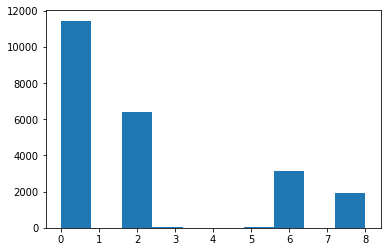

In [64]:
# some explanatory of which method used how much
plt.hist(id_of_best_calc.values())
plt.show()

## Final forecast for the competition

In [68]:
# id_of_best_calc = {row_id:0 for row_id in train['Yearly']['V1']} # for debug purposes
preds_final, _ = fealess5(train=train_f, test=None, datasets=[], verbose=False, variation_pick=id_of_best_calc)

picked dataset(s) :  ['Yearly', 'Weekly', 'Quarterly', 'Monthly', 'Hourly', 'Daily']
starting row:  -1
Yearly


A Jupyter Widget

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  



Weekly


A Jupyter Widget


Quarterly


A Jupyter Widget


Monthly


A Jupyter Widget


Hourly


A Jupyter Widget


Daily


A Jupyter Widget

# Save the predictions

In [69]:
# in case some errors occured and the last predictions can be saved and 
# the process continued to obtain the rest and merge all together at the end
# merged = {}
# merged.update(preds1)
# merged.update(preds2)
# merged.update(preds3)
# merged.update(preds_holdout)

all_preds_holdout = pd.DataFrame.from_dict(preds_holdout, orient='index')
all_preds_holdout.to_csv("fearless5_all_holdout.csv", float_format='%.f')

all_preds_final = pd.DataFrame.from_dict(preds_final, orient='index')
all_preds_final.to_csv("fearless5_all_test.csv", float_format='%.f')